In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging
import re
import warnings
warnings.filterwarnings("ignore")
import torch.nn.functional as F
from tqdm import tqdm

logging.set_verbosity_error()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
class focal_loss(nn.Module):
    def __init__(self, alpha: float = 0.25, gamma: float = 2, reduction: str = "none"):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        
    def forward(self, inputs: torch.Tensor, targets: torch.Tensor):
        """
        Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
        Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

        Args:
            inputs: A float tensor of arbitrary shape.
                    The predictions for each example.
            targets: A float tensor with the same shape as inputs. Stores the binary
                    classification label for each element in inputs
                    (0 for the negative class and 1 for the positive class).
            alpha: (optional) Weighting factor in range (0,1) to balance
                    positive vs negative examples or -1 for ignore. Default = 0.25
            gamma: Exponent of the modulating factor (1 - p_t) to
                   balance easy vs hard examples.
            reduction: 'none' | 'mean' | 'sum'
                     'none': No reduction will be applied to the output.
                     'mean': The output will be averaged.
                     'sum': The output will be summed.
        Returns:
            Loss tensor with the reduction option applied.
        """

#         if not torch.jit.is_scripting() and not torch.jit.is_tracing():
#             _log_api_usage_once(sigmoid_focal_loss)
        p = torch.sigmoid(inputs)
        ce_loss = F.cross_entropy(inputs, targets, reduction="none")
        p_t = p * targets + (1 - p) * (1 - targets)
        loss = ce_loss * ((1 - p_t) ** self.gamma)

        if self.alpha >= 0:
            alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
            loss = alpha_t * loss

        if self.reduction == "mean":
            loss = loss.mean()
        elif self.reduction == "sum":
            loss = loss.sum()

        return loss

In [3]:
device = torch.device('cuda')

In [4]:
from transformers import AutoTokenizer

# tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("MoritzLaurer/ernie-m-large-mnli-xnli")

In [5]:
# test_dict_answer
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline


In [6]:
def preprocess_text(text: str) -> str:    
    text = re.sub(r"['\",\.\?:\-!]", "", text)
    text = text.strip()
    text = " ".join(text.split())
    text = text.lower()
    return text

In [7]:
# status['claim']#     example = "Phát biểu tại phiên thảo luận về tình hình kinh tế xã hội của Quốc hội sáng 28/10 , Bộ trưởng Bộ LĐ-TB&XH Đào Ngọc Dung khái quát , tại phiên khai mạc kỳ họp , lãnh đạo chính phủ đã báo cáo , đề cập tương đối rõ ràng về việc thực hiện các chính sách an sinh xã hội"
tokenizer_seg = AutoTokenizer.from_pretrained("NlpHUST/vi-word-segmentation")
model_seg = AutoModelForTokenClassification.from_pretrained("NlpHUST/vi-word-segmentation")
nlp = pipeline("token-classification", model=model_seg, tokenizer=tokenizer_seg, device=0)

def segmentation_token(example):
#     example = preprocess_text(example)
    ner_results = nlp(example)
    ner =[]
    example_tok = ""
    for e in ner_results:
        if "##" in e["word"]:
            example_tok = example_tok + e["word"].replace("##","")
        elif e["entity"] =="I":
            example_tok = example_tok + "_" + e["word"]
            ner.append(example_tok.split(' ')[-1])
        else:
            example_tok = example_tok + " " + e["word"]

    return example_tok

In [8]:
segmentation_token("Nguyen Van Nam")

' Nguyen_Van_Nam'

In [9]:
class Data(Dataset):
    def __init__(self, df, tokenizer, max_len=400):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __len__(self):
        return len(self.df)
#     def get_top_sentence(self, context, claim):
        
    def __getitem__(self, index):
        row = self.df.iloc[index]
        claim, context, label, ids = self.get_input_data(row)
#         claim = segmentation_token(claim)
#         context = select_sentance_text(claim=claim, context=context)
#         text = claim + '. ' + evidence
        
        encoding = self.tokenizer.encode_plus(
            claim,
            context,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )
        
        return {
#             'text': text,
            'id': ids,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }


    def labelencoder(self, text):
        if text=='NEI':
            return 0
        elif text=='SUPPORTED':
            return 1
        else:
            return 2

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        claim = row['claim']
        if row['verdict']=='NEI':
            context = row['sentence_highest']
        else:
            context = row['evidence']
        ids = row['id']
#         text = ' '.join(simple_preprocess(text))
        label = self.labelencoder(row['verdict'])
        
        return str(claim), str(context), label, ids

In [10]:
class ClaimVerification(nn.Module):
    def __init__(self, n_classes):
        super(ClaimVerification, self).__init__()
        self.bert = AutoModel.from_pretrained("MoritzLaurer/ernie-m-large-mnli-xnli")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [11]:
from tqdm.notebook import tqdm

def train(model, criterion, optimizer, train_loader, accumulation_steps = 16 ):
    model.train()
    losses = []
    correct = 0
    i = 0
    for data in tqdm(train_loader):
#         print(data['targets'])
        y_true = data['targets'].to(device)
        targets = F.one_hot( data['targets'], 3)
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = targets.to(device,dtype=torch.float)
        
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        
        loss = criterion(outputs, targets)
        loss = loss / accumulation_steps
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == y_true)
        losses.append(loss.item())
        loss.backward()
        if (i+1) % accumulation_steps == 0: 
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
        i+=1

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval(test_data = False):
    model.eval()
    losses = []
    correct = 0

    with torch.no_grad():
        data_loader = test_loader if test_data else valid_loader
        for data in data_loader:
            y_true = data['targets'].to(device)
            targets = F.one_hot( data['targets'], 3)
            
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets =targets.to(device,dtype=torch.float)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == y_true)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(test_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(test_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(valid_loader.dataset)


In [12]:
model = ClaimVerification(n_classes=3).to(device)

Data train

In [13]:
train_data = pd.read_csv('/kaggle/input/ise-classify-data/train.csv').reset_index()
test_data = pd.read_csv('/kaggle/input/ise-classify-data/test.csv').reset_index()

In [14]:
train_data.columns

Index(['index', 'Unnamed: 0', 'context', 'claim', 'verdict', 'evidence',
       'domain', 'id', 'sentence_highest'],
      dtype='object')

In [18]:
# train_data = train_data[train_data.verdict != 'NEI']
test_data.verdict.value_counts()

verdict
NEI          1276
SUPPORTED    1000
REFUTED      1000
Name: count, dtype: int64

In [20]:
# test_data = test_data[test_data.verdict != 'NEI']
train_data.verdict.value_counts()

verdict
NEI          11000
REFUTED       7000
SUPPORTED     7000
Name: count, dtype: int64

In [21]:
train_df = train_data
test_df = test_data

<Axes: xlabel='verdict', ylabel='count'>

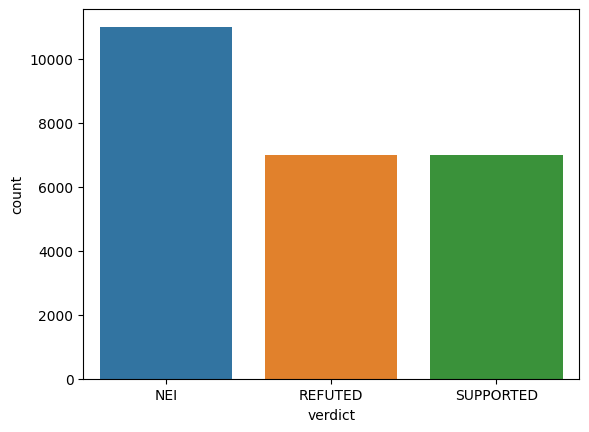

In [22]:
sns.countplot(x='verdict', data=train_df)

In [23]:
print(train_df.verdict.value_counts())

verdict
NEI          11000
REFUTED       7000
SUPPORTED     7000
Name: count, dtype: int64


In [24]:
print(test_df.verdict.value_counts())

verdict
NEI          1276
SUPPORTED    1000
REFUTED      1000
Name: count, dtype: int64


In [25]:
# train_df = train_df.head(300)
# test_df = test_df.head(300)

In [26]:
train_dataset = Data(train_df, tokenizer, max_len=256)
test_dataset = Data(test_df, tokenizer, max_len=256)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=2)

In [27]:
class Parameter_model:
    def __init__(self):
        self.channels_last = None
        self.pretrained = True
        self.in_chans = 3
        self.num_classes = 3
        self.drop = 0.5
        self.drop_path = 0.2
        self.gp = 'avg'
        self.num_epochs = 100

        self.lr = 0.000001
        self.grad_checkpointing = True
        self.channels_last = True
        self.model = "efficientnet_b0"
        self.smoothing = 0.1
        self.min_lr = 5e-5
        self.warmup_epochs = 4
        self.warmup_lr =  3e-5
        self.eval_metric = 'loss'
        self.apex = True
        self.gem =True
        self.check_point = None
        self.loss = 'fl'
        self.alpha = 0.25
        self.gamma = 2
        self.reduction = 'mean'
        self.loss = 'fl'
        self.gem = False
        self.path_checkpoint  = None

In [28]:
config = Parameter_model()

In [29]:
# criterion = focal_loss(config.alpha, config.gamma, config.reduction).to(device=device)
criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=3e-5)

In [30]:
print('lr = 3e-5')

lr = 3e-5


In [31]:
EPOCHS = 50

In [32]:
lr_scheduler = get_linear_schedule_with_warmup(
                optimizer, 
                num_warmup_steps=0, 
                num_training_steps=len(train_loader)*EPOCHS
            )

In [33]:
# torch.multiprocessing.set_start_method('spawn')

In [34]:
best_acc = 0
cnt = 0
for epoch in range(EPOCHS):

    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)

    train(model, criterion, optimizer, train_loader)
    val_acc = eval(test_data = True)
    
#     torch.save(model.state_dict(), f'phobert_epoch{epoch+1}.pth')
    
    if val_acc > best_acc:
        cnt = 0
        torch.save(model.state_dict(), f'best_acc.pth')
        print(f'save best_acc.pth with epoch {epoch+1}')
        best_acc = val_acc
    else:
        cnt+=1
    if cnt >=5 :
        print('Stop model')
        break
        
        save_model(epoch, model, optimizer, criterion)
        

Epoch 1/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.8222400000000001 Loss: 0.028899377667421067
Test Accuracy: 0.873015873015873 Loss: 0.3382997513486877
save best_acc.pth with epoch 1
Epoch 2/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9026400000000001 Loss: 0.01649956667415856
Test Accuracy: 0.8852258852258852 Loss: 0.345297020414646
save best_acc.pth with epoch 2
Epoch 3/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.94388 Loss: 0.01007049646199088
Test Accuracy: 0.8904151404151404 Loss: 0.37249821268637506
save best_acc.pth with epoch 3
Epoch 4/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9596800000000001 Loss: 0.007410234158127405
Test Accuracy: 0.8983516483516484 Loss: 0.40546200109948366
save best_acc.pth with epoch 4
Epoch 5/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9722400000000001 Loss: 0.005144554354751026
Test Accuracy: 0.8962148962148963 Loss: 0.3907269131386961
Epoch 6/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9742400000000001 Loss: 0.0048424108030861775
Test Accuracy: 0.8916361416361417 Loss: 0.4547799999578369
Epoch 7/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9672000000000001 Loss: 0.005873113398930737
Test Accuracy: 0.891941391941392 Loss: 0.42150436087762105
Epoch 8/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.97484 Loss: 0.0047129165266634665
Test Accuracy: 0.8998778998778999 Loss: 0.41561616588166894
save best_acc.pth with epoch 8
Epoch 9/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9832400000000001 Loss: 0.0031960746356548405
Test Accuracy: 0.9038461538461539 Loss: 0.4419007558096956
save best_acc.pth with epoch 9
Epoch 10/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.98616 Loss: 0.0027101026640045348
Test Accuracy: 0.895909645909646 Loss: 0.39463661272022876
Epoch 11/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9834800000000001 Loss: 0.003207513129469071
Test Accuracy: 0.8928571428571429 Loss: 0.5181732342974837
Epoch 12/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9746400000000001 Loss: 0.004476036372751278
Test Accuracy: 0.8913308913308914 Loss: 0.4886101658091872
Epoch 13/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9855200000000001 Loss: 0.002676546385740785
Test Accuracy: 0.9014041514041514 Loss: 0.47095109880494146
Epoch 14/50
------------------------------


  0%|          | 0/12500 [00:00<?, ?it/s]

Train Accuracy: 0.9890000000000001 Loss: 0.0020567225734184104
Test Accuracy: 0.8968253968253969 Loss: 0.5819207336299836
Stop model


In [35]:
def test(data_loader):
    models = []
    for epoch in range(1):
        model = ClaimVerification(n_classes=3)
        model.to(device)
        model.load_state_dict(torch.load(f'best_acc.pth'))
        model.eval()
        models.append(model)

    id_list = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
#         text = data['text']
        
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        total_outs = []
        for model in models:
            with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
                total_outs.append(outputs)
        
        total_outs = torch.stack(total_outs)
        _, pred = torch.max(total_outs.mean(0), dim=1)
#         texts.extend(text)
        id_list.extend(data['id'])
        predicts.extend(pred)
        predict_probs.extend(total_outs.mean(0))
        real_values.extend(targets)
    id_list = torch.stack(id_list).cpu()
    predicts = torch.stack(predicts).cpu()
    predict_probs = torch.stack(predict_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts, id_list

In [36]:
# test_dataset = Data(test_df, tokenizer, max_len=200)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts, id_list = test(test_loader)

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      1276
           1       0.90      0.90      0.90      1000
           2       0.91      0.91      0.91      1000

    accuracy                           0.90      3276
   macro avg       0.90      0.90      0.90      3276
weighted avg       0.90      0.90      0.90      3276



In [37]:
id_wrong =[]
for i in range(len(real_values)):
#     print(predicts[i].item())
    if  predicts[i].item() == 0:
        id_wrong.append(id_list[i].item())

In [38]:
# id_wrong

In [39]:
len(id_wrong)

1279

In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay, confusion_matrix, roc_curve, auc


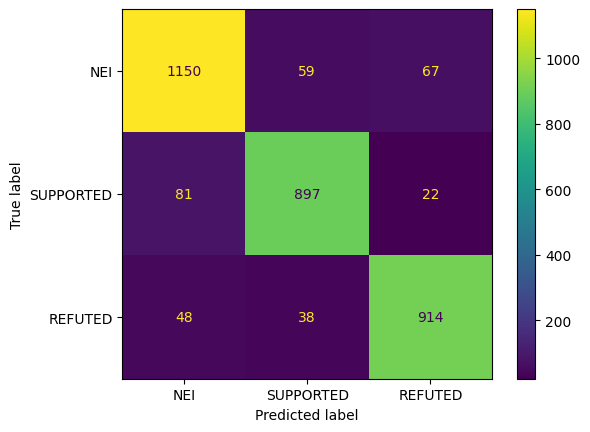

In [41]:
cm = confusion_matrix(real_values, predicts)
cr = classification_report(real_values, predicts)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['NEI','SUPPORTED', 'REFUTED'])
disp.plot()
plt.savefig('confusion_matrix.png')
plt.show()